In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime
import re
import json
import spacy
import string
import wordcloud 
from wordcloud import WordCloud
from causalimpact import CausalImpact
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn import metrics
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc


VADER is a lexicon and rule-based sentiment analysis tool, specific in a Social-media context. 

In [196]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Consider the same dataset as in Milestone 2

In [197]:
# build a personalyze data parser
custom_date = lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d')
df = pd.read_csv('tweets.csv', parse_dates=['date'], date_parser=custom_date)
df = df[df['date'] >= '2019-12-01']
df = df.sort_values(by='date')


C:\Users\User\AppData\Local\Temp\ipykernel_3568\3465479924.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('tweets.csv', parse_dates=['date'], date_parser=custom_date)


Define a funcrion to get and plot the aggregate sentiment of the tweets in the dataset.

In [198]:
def get_sentiment_(df):
  #get the scores of each tweet
  df['scores'] = df['text'].apply(lambda Description: sid.polarity_scores(Description)) 

  #calculate the sentiment score which is a combination of positive, negative and neutral(not mean)
  df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
  df['sentiment_type']=''
  df.loc[df.compound>0,'sentiment_type']='POSITIVE'
  df.loc[df.compound==0,'sentiment_type']='NEUTRAL'
  df.loc[df.compound<0,'sentiment_type']='NEGATIVE'

  #aggrergate by day month and year # we want to inspect aggregate value per day, week and month
  df['month_date'] = df.date.apply(lambda x: x.month)
  df['year_date'] = df.date.apply(lambda x: x.year)
  df['daily'] = df.date.apply(lambda x: x.day)
  df['week'] = df['date'].dt.isocalendar().week

  # take the mean of the compound value for each day, week and month
  #daily
  freq_d = df.groupby(by=['year_date','month_date','daily']).apply(lambda x: x.compound.mean())
  freq_d = freq_d.reset_index()
  freq_d = freq_d.rename(columns={0: 'compound'})
  
  #weekly
  freq_w = df.groupby(['year_date','month_date','week']).apply(lambda x: x.compound.mean())
  freq_w = freq_w.reset_index()
  freq_w = freq_w.rename(columns={0: 'compound'})

  #monthly
  freq_m = df.groupby(by=['year_date','month_date']).apply(lambda x: x.compound.mean())
  freq_m = freq_m.reset_index()
  freq_m = freq_m.rename(columns={0: 'compound'})

  # drop week first last two weeks unresonable values
  freq_w = freq_w.iloc[1:-1]

  #monthly
  freq_m.year_date = freq_m.year_date.astype(str)
  freq_m.month_date = freq_m.month_date.astype(str)
  freq_m['date'] = freq_m.apply(lambda x: datetime.strptime(str(x.year_date) + '-' + str(x.month_date), '%Y-%m'), axis=1)

  #manipulation to get nice plot
  #daily
  freq_d.year_date = freq_d.year_date.astype(str)
  freq_d.month_date = freq_d.month_date.astype(str)
  freq_d.daily = freq_d.daily.astype(str)
  freq_d['date'] = freq_d.apply(lambda x: datetime.strptime(str(x.year_date) + '-' + str(x.month_date) + '-' + str(x.daily), '%Y-%m-%d'), axis=1)

  #weekly
  freq_w.year_date = freq_w.year_date.astype(str)
  freq_w.month_date = freq_w.month_date.astype(str)
  freq_w.week = freq_w.week.astype(str)
  freq_w['date'] = pd.to_datetime(freq_w['year_date'].astype(str) + freq_w['week'].astype(str) + '-1', format='%G%V-%u')

  plt.figure(figsize=(10, 6))

  # Plotting freq_m
  plt.plot(freq_m['date'], freq_m['compound'], label='Monthly' , linestyle='-')

  # Plotting freq_d
  plt.plot(freq_d['date'], freq_d['compound'], label='Daily', linestyle='-')

  # Plotting freq_w
  plt.plot(freq_w['date'], freq_w['compound'], label='Weekly', linestyle='-')

  plt.xlabel('Date')
  plt.ylabel('Compound Value')
  plt.title('Compound Values Over Time')
  plt.legend()
  plt.xticks(rotation=45) 
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  return df, freq_d

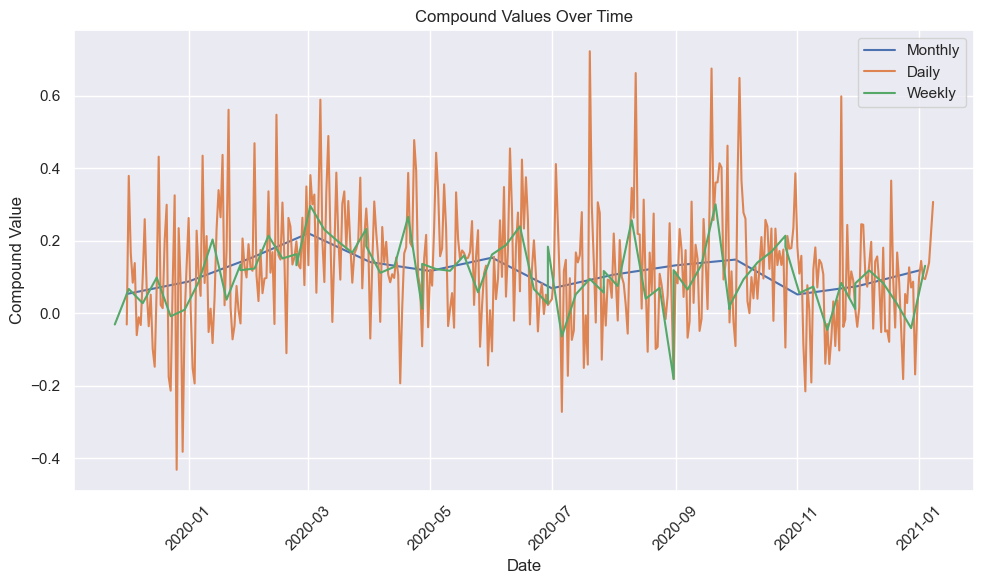

In [199]:
data_tot, freq_d = get_sentiment_(df)

The aggregate timeseries of the sentiment shows some interesting features:
- The sentiment in Trump's tweet is mainly positive: as soon as the aggregation becomes weekly the aggregate sentiment becomes negative in a extremly limited numer of weeks. Further dimnuishibg the granularity of the aggregation (monthly) the sentiment becomes always positive.
- No aggregate tweets have a sentiment score above 0.6 or under -0.4, however we can see, fixing as a threshold $\pm 0.4$ thate the 'positive spikes' are much more frequent than the 'negative spikes'.

There could be two reasons for this:
- The first one is that, as a politician, Trump is more likely to tweet about positive events than negative ones. Bringing up to surface and enphatizing positive events about himslef is a way to get consensus.
-The second one is that the VADER lexicon is not able to capture the sentiment of the tweets. Or at least the sarcastic ones. Even if Vader is specific for social media, the sarcasm detection is something pretty difficult to achieve, hence there could be some bias due to the high number of sarcastic tweets.

To clarify this doubts we can plot the sentiment about Joe Biden, we except to be negative, since he is the opponent of Trump.

In [200]:
# now look at Joe Biden tweets
#create a list of words related to Joe Biden
biden_words = ['Joe', 'Biden', 'Democrat', 'democrat', 'democratic', 'Democratic', 'president', 'President', 'VP', 'vice president', 'Vice President', 'Kamala', 'Harris', 'Kamala Harris', 'KamalaHarris', 'KamalaHarrisVP', 'KamalaHarrisVPPresident', 'KamalaHarrisV']
df['biden_related'] = df['text'].apply(lambda x: True if any(word in x for word in biden_words) else False)
#data where covid_related is true
data_biden_rel = df[df['biden_related']==1]

C:\Users\User\AppData\Local\Temp\ipykernel_3568\3441226468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scores'] = df['text'].apply(lambda Description: sid.polarity_scores(Description))
C:\Users\User\AppData\Local\Temp\ipykernel_3568\3441226468.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
C:\Users\User\AppData\Local\Temp\ipykernel_3568\3441226468.py:7: SettingWithCopyWarning: 
A value is trying to be set on a c

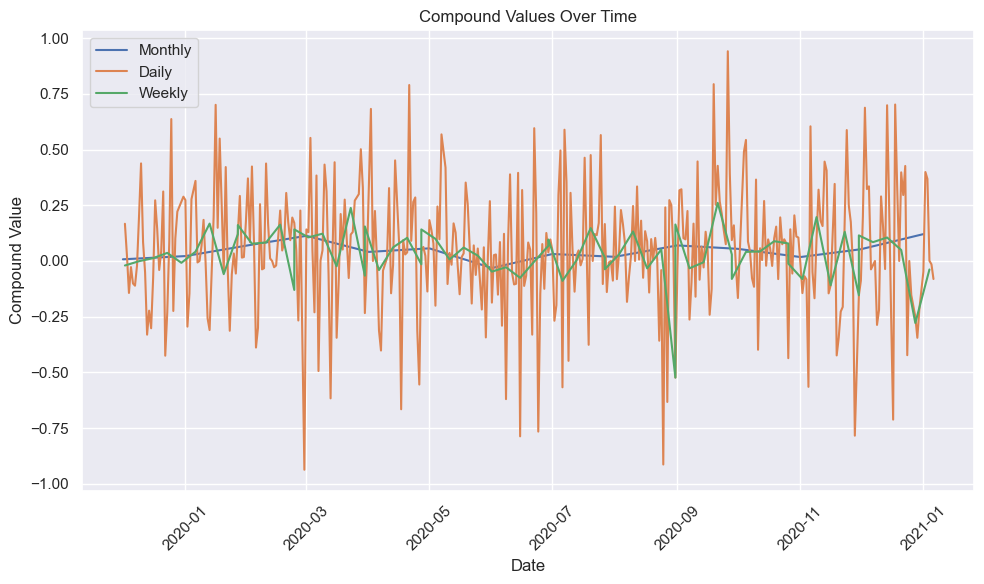

In [201]:
data_biden, freq_d_biden = get_sentiment_(data_biden_rel)

When examining the data concerning Biden, the sentiment appears to hover closer to neutrality (around 0), particularly when aggregated on a monthly basis, where it consistently remains slightly above 0. The spikes in sentiment are more evenly distributed, suggesting a balanced spectrum of opinions. However, it's crucial to approach these results with caution as sentiment analysis tools like VADER may not entirely capture the nuances of sarcasm evident in some of Trump's tweets.

## Covid Related Tweets

C:\Users\User\AppData\Local\Temp\ipykernel_3568\3441226468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scores'] = df['text'].apply(lambda Description: sid.polarity_scores(Description))
C:\Users\User\AppData\Local\Temp\ipykernel_3568\3441226468.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
C:\Users\User\AppData\Local\Temp\ipykernel_3568\3441226468.py:7: SettingWithCopyWarning: 
A value is trying to be set on a c

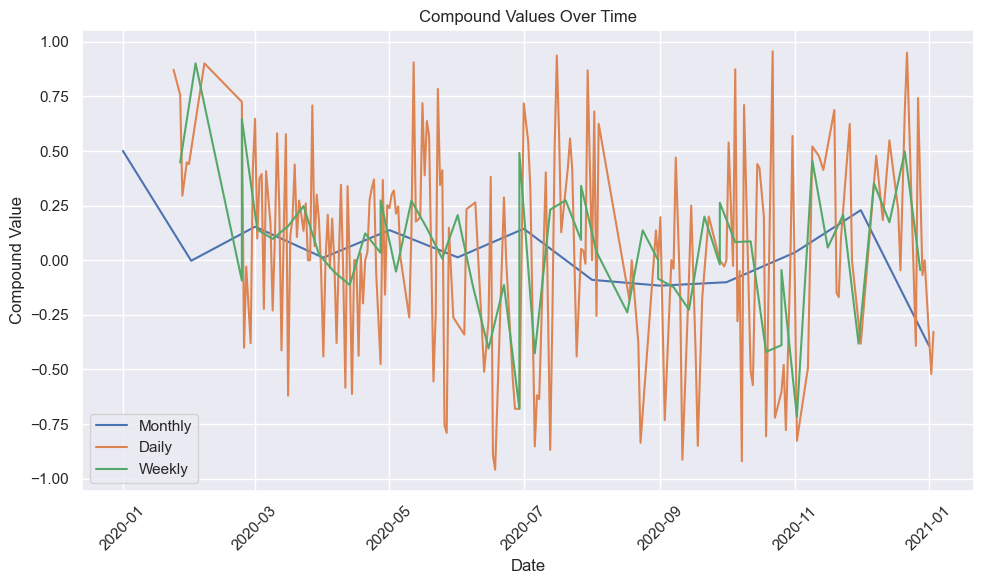

In [202]:
# now look at covid tweets
#create a list of words related to covid
list_of_words = ['Covid19' ,'virus', 'vaccine', 'Flu', 'Covid', 'lockdown', 'pandemic', 'coronavirus', 'Coronavirus', 'Corona', 'corona', 'COVID19', 'COVID', 'covid', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantined', 'Quarantined', 'quarentined', 'Quarentined', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines']
df['covid_related'] = df['text'].apply(lambda x: True if any(word in x for word in list_of_words) else False)
#data where covid_related is true
data_covid_rel = df[df['covid_related']==1]
drr, freq_dc = get_sentiment_(data_covid_rel)

The sentiment is way more volatile than the two cases considered above. This is due to the fact we have less data about covid, however, in contrast to the previous trade, it seems there is a slightly negative trend in the sentiment. This could be due to the fact that the pandemic is still ongoing and the situation is not improving. It is also probable that sarcasm related to Covid-19 is less frequent than the one related to politics. 

We focus on the period were Covid-19 was spreading in the US. From our data-visualization we already assess that march-april was the period with the highest number of tweets related to Covid in Trump's tweet dataset.

In [203]:
#subset old one
start_date = '2020-03-19'
end_date = '2020-04-18'
freq_d_subc = freq_dc[(freq_dc['date'] >= start_date) & (freq_dc['date'] <= end_date)]

## Predictive analysis

We want to see if we find predictors for Trump's tweets sentiment.
From kaggle datset 20 March - 18 April, data from kaggle sentiment among people in US.<p>
The Idea is to see if sentiment in population has predictive power on Trump's tweets sentiment.

In [204]:
#import datasets
combined_df = pd.DataFrame()
file_path = 'data'
files = [file for file in os.listdir(file_path)]
# Create a list of DataFrames by reading each CSV file
dataframes = [pd.read_csv(file_path+'/'+file) for file in files]

# Concatenate the list of DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df= combined_df.dropna(subset=['text'])

Create column date combining year, month and day

In [205]:
combined_df.user_location.value_counts()
US_df = combined_df[combined_df['user_location']=='United States']
US_df['date']=pd.to_datetime(US_df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y', errors='coerce').dt.floor('D') 

C:\Users\User\AppData\Local\Temp\ipykernel_3568\1456329594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_df['date']=pd.to_datetime(US_df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y', errors='coerce').dt.floor('D')


In [206]:
US_df.loc[:,'scores'] = US_df['text'].apply(lambda review: sid.polarity_scores(review))

C:\Users\User\AppData\Local\Temp\ipykernel_3568\3243912476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_df.loc[:,'scores'] = US_df['text'].apply(lambda review: sid.polarity_scores(review))


Sentiment analysis with vader

In [207]:
US_df['compound']  = US_df['scores'].apply(lambda score_dict: score_dict['compound'])

C:\Users\User\AppData\Local\Temp\ipykernel_3568\2988745508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_df['compound']  = US_df['scores'].apply(lambda score_dict: score_dict['compound'])


In [208]:
US_df=US_df[US_df['compound']!=0]
US_df_agg = US_df['compound'].groupby(US_df['date']).mean().reset_index()

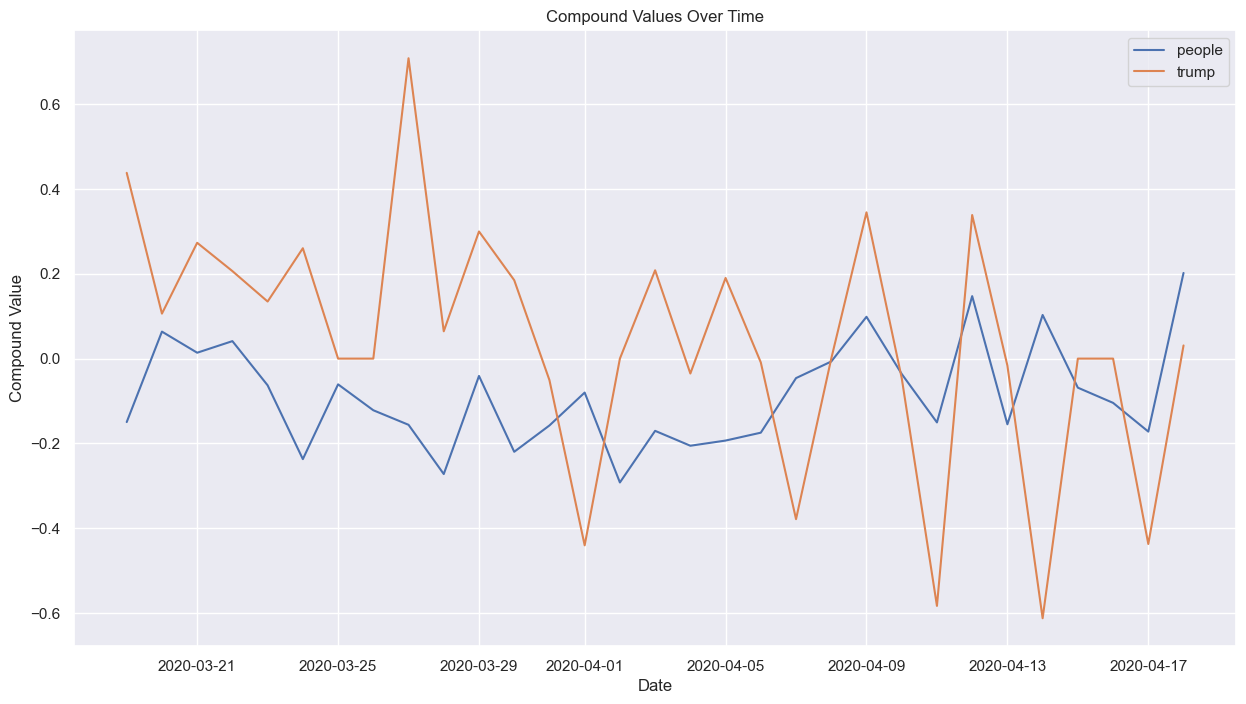

In [209]:
plt.plot(US_df_agg['date'], US_df_agg['compound'], label='people', linestyle='-')
plt.plot(freq_d_subc['date'], freq_d_subc['compound'], label='trump', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Compound Value')
plt.title('Compound Values Over Time')
plt.legend()
plt.show()

merge dataframes with people sentiment and trump sentiment

In [210]:
merged_dfc = pd.merge(US_df_agg, freq_d_subc, on='date', how='inner')
merged_dfc.rename(columns={'compound_x': 'people', 'compound_y': 'Trump'}, inplace=True)

Now we have a dataset with only tweets about covid, let's see if there is a correlation between the sentiment of the people about covid and the sentiment of Trump's tweets(only about covid)

In [211]:
merged_dfc['Trump_sent']= merged_dfc['Trump'].apply(lambda x: 1 if x>0 else 0 )
merged_dfc['people_sent']= merged_dfc['people'].apply(lambda x: 1 if x>0 else 0)

In [212]:
mod_1 = smf.logit(formula='Trump_sent ~ people_sent ', data=merged_dfc)
res_1 = mod_1.fit()
print(res_1.summary())

Optimization terminated successfully.
         Current function value: 0.604785
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             Trump_sent   No. Observations:                   31
Model:                          Logit   Df Residuals:                       29
Method:                           MLE   Df Model:                            1
Date:                Fri, 15 Dec 2023   Pseudo R-squ.:                  0.1268
Time:                        10:56:51   Log-Likelihood:                -18.748
converged:                       True   LL-Null:                       -21.471
Covariance Type:            nonrobust   LLR p-value:                   0.01961
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.5108      0.422     -1.212      0.226      -1.337       0.316
people_sent     2.3026    

We see that the people sentiment variable has a positive correation with Trump's tweet sentiment. It is significative at 5% level, then we have predictive power. 

## Predictive analysis (2)

Let's consider a timeseries of new cases of covid in US and see if the variation of the new cases can be used to predict Trump's sentiment tweets the dataset reports the absolute number of new cases, we need to calculate the variation of new cases.

In [213]:
covid = pd.read_csv('timesco/time-series-19-covid-combined.csv')
covid.head()

cov_us = covid[covid['Country/Region']=='US']
sub_cov = cov_us[(cov_us['Date'] >= start_date) & (cov_us['Date'] <= end_date)]

Add the columns with people and Trump sentiment

In [214]:
sub_cov.loc[:,'trump_sent'] = merged_dfc['Trump_sent'].values
sub_cov.loc[:,'peopl_sent'] = merged_dfc['people_sent'].values
sub_cov.loc[:,'Trump']= merged_dfc['Trump'].values
sub_cov.loc[:,'people']= merged_dfc['people'].values

C:\Users\User\AppData\Local\Temp\ipykernel_3568\344740220.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_cov.loc[:,'trump_sent'] = merged_dfc['Trump_sent'].values
C:\Users\User\AppData\Local\Temp\ipykernel_3568\344740220.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_cov.loc[:,'peopl_sent'] = merged_dfc['people_sent'].values
C:\Users\User\AppData\Local\Temp\ipykernel_3568\344740220.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Try logistic regression

In [215]:
logit_df = sub_cov.copy()

variation of cases in new cases, in the dataframe we have absolute numbers

In [216]:
logit_df['increase_new_cases'] = logit_df['Confirmed'].shift(1)-logit_df['Confirmed']/logit_df['Confirmed']

In [217]:
logit_df['Confirmed']= (logit_df['Confirmed']-logit_df['Confirmed'].mean())/logit_df['Confirmed'].std()
logit_df['Recovered']= (logit_df['Recovered']-logit_df['Recovered'].mean())/logit_df['Recovered'].std()
logit_df['Deaths']= (logit_df['Deaths']-logit_df['Deaths'].mean())/logit_df['Deaths'].std()
logit_df['increase_new_cases']= (logit_df['increase_new_cases']-logit_df['increase_new_cases'].mean())/logit_df['increase_new_cases'].std()

In [218]:
mod5 = smf.logit(formula='trump_sent ~ increase_new_cases ', data=logit_df)
res5 = mod5.fit()
print(res5.summary())

Optimization terminated successfully.
         Current function value: 0.603617
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             trump_sent   No. Observations:                   30
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            1
Date:                Fri, 15 Dec 2023   Pseudo R-squ.:                  0.1264
Time:                        10:56:51   Log-Likelihood:                -18.109
converged:                       True   LL-Null:                       -20.728
Covariance Type:            nonrobust   LLR p-value:                   0.02209
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1785      0.404     -0.442      0.658      -0.969       0.612
incre

From the summary we can see that the variation of new cases has a negative correlation with Trump's sentiment tweets. It is significative at 5% level, then we have predictive power.
It is reasonable since we expect that if the number of new cases is increasing, Trump's sentiment is worsening.

## Predictive analysis combined

Let's combine the two models, let's see if the variables keep their predictive power, and how the model performs.

In [219]:
mod6 = smf.logit(formula='trump_sent ~ peopl_sent + increase_new_cases', data=logit_df)
res6 = mod6.fit()
print(res6.summary())

Optimization terminated successfully.
         Current function value: 0.426899
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             trump_sent   No. Observations:                   30
Model:                          Logit   Df Residuals:                       27
Method:                           MLE   Df Model:                            2
Date:                Fri, 15 Dec 2023   Pseudo R-squ.:                  0.3821
Time:                        10:56:51   Log-Likelihood:                -12.807
converged:                       True   LL-Null:                       -20.728
Covariance Type:            nonrobust   LLR p-value:                 0.0003631
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.2070      0.679     -1.777      0.076      -2.538       0.124
peopl

All the results we got in the previous models are confirmed, the two variables have predictive power and the model performs well. Actually the p-values are ven lower than in the previous models, both variables are significative at 2.5% level.

It seems that both variables have predictive power, let's scale the increment in new cases between -1 and 1 with min max scaler, so that they are directly comparable to the sentiment variables.

In [220]:
# Assuming 'data' is the variable you want to scale
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = logit_df['increase_new_cases'].values.reshape(-1, 1)  # If 'data' is a pandas Series
logit_df['scaled_new'] = scaler.fit_transform(scaled)


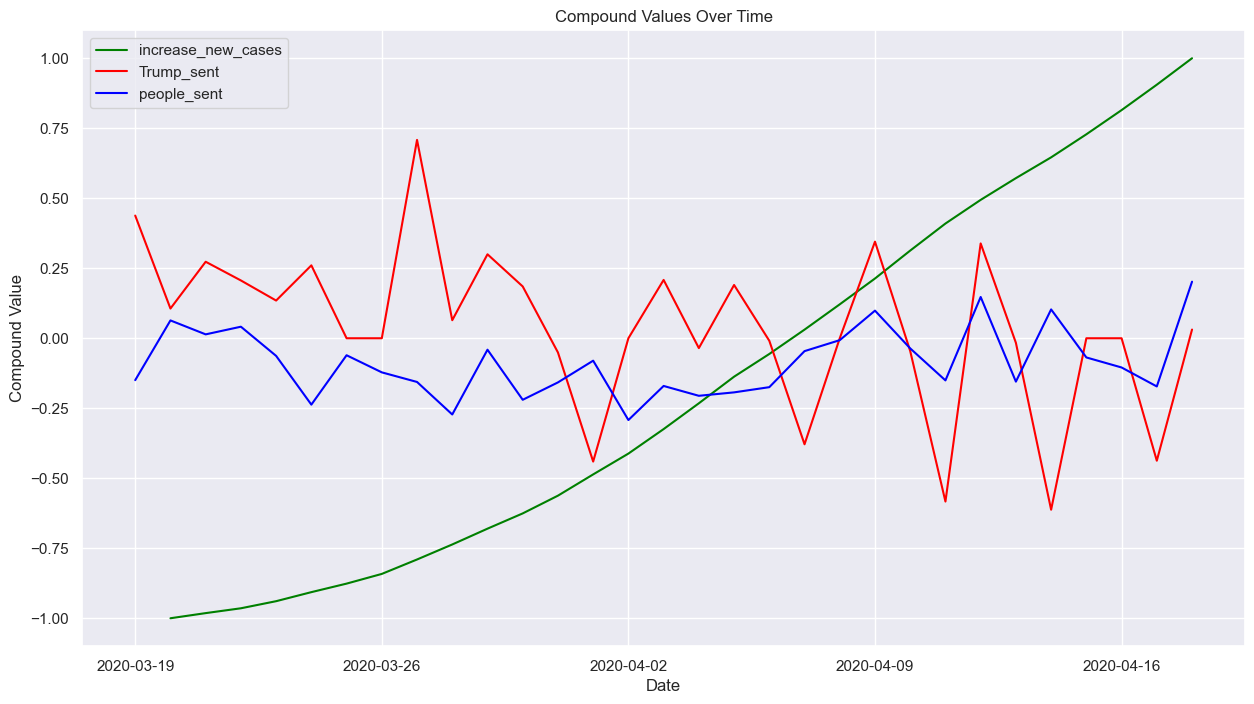

In [221]:
# plots
plt.plot(logit_df['Date'], logit_df['scaled_new'], label='increase_new_cases', linestyle='-',color='green')
plt.plot(logit_df['Date'], logit_df['Trump'], label='Trump_sent', linestyle='-',color='red')
plt.plot(logit_df['Date'], logit_df['people'], label='people_sent', linestyle='-', color='blue')

n = 7 
plt.xticks(logit_df['Date'][::n])
plt.xlabel('Date')
plt.ylabel('Compound Value')
plt.title('Compound Values Over Time')
plt.legend()
plt.show()


The plot show that the two sentiment variables comove, at least is the period considered. It also noticible that the sentiments variables are negatively correlated with the variation of new cases, as expected. The trend of the variation of new cases is raising sharply, wherease the sentiment of the sentiment variables have a general negative trend.

In [222]:
y_pred = res6.predict(logit_df[['peopl_sent', 'increase_new_cases']])
y_pred = [ 1 if y>=0.5 else 0 for y in y_pred]

Let's plot the confusion Matrix

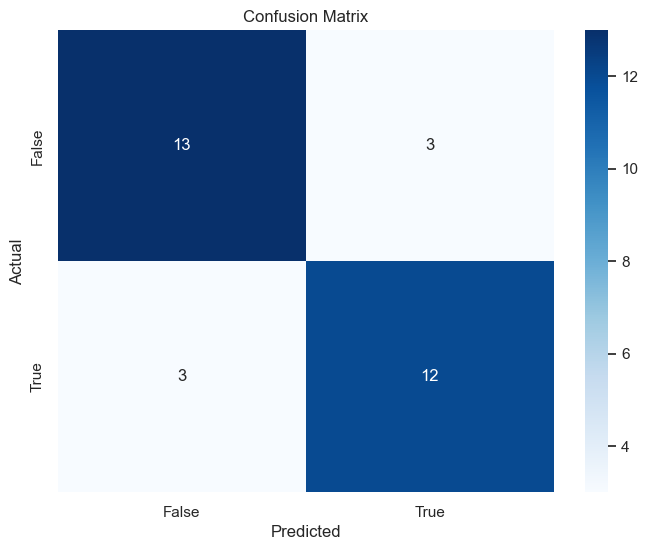

In [224]:
confusion_matrix = metrics.confusion_matrix(logit_df.trump_sent, y_pred)
labels = ['False', 'True']  

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()


In [231]:
precision = confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1])
recall = confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0])
f1 = 2*(precision*recall)/(precision+recall)
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 Score: {:.3f}'.format(f1))

Precision: 0.800
Recall: 0.800
F1 Score: 0.800


The result we get are really good we have a precision of 0.8 and a recall of 0.8, the model is able to predict the sentiment of Trump's tweets with a good accuracy and recall. Our analysis last 30 days but the values are aggregated on a daily basis so our results can be considered reliable. 

In [225]:
#fill the miss values given with the mean value
logit_df['increase_new_cases']=logit_df['increase_new_cases'].fillna(logit_df['increase_new_cases'].mean())

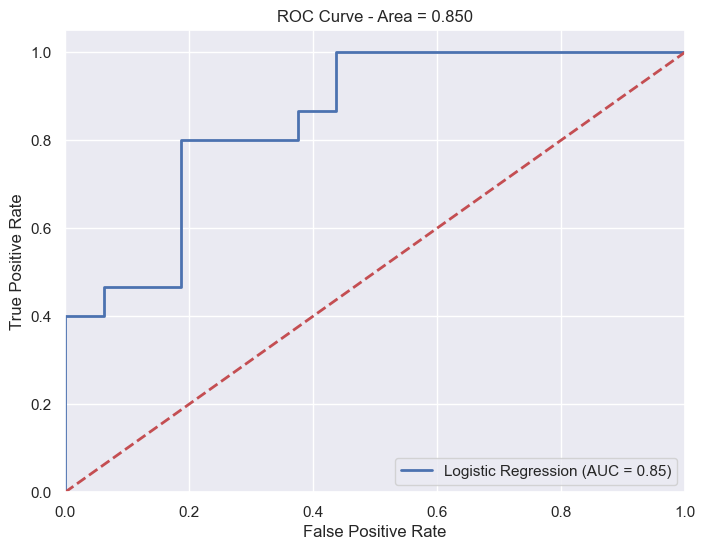

In [229]:
logit_probs = res6.predict(logit_df[['peopl_sent', 'increase_new_cases']])

# Calculate ROC curve and AUC
logit_roc_auc = roc_auc_score(logit_df['trump_sent'], logit_probs)
fpr, tpr, thresholds = roc_curve(logit_df['trump_sent'], logit_probs)
auc_score = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % logit_roc_auc, linewidth=2)
plt.plot([0, 1], [0, 1], 'r--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve - Area = {:.3f}".format(auc_score))
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


AUC at 0.85 is a good result, it means that the model is able to distinguish between positive and negative sentiment with a good accuracy. We expected that since the accuracy is high.